In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import patsy
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv("../data/cleaned/df_eda.csv")

In [49]:
#df['osteosarcopenia'].unique()

# conversión binaria de variable osteosarcopenia
df['osteosarcopenia'] = df['osteosarcopenia'].astype(int)

In [50]:
df['clasificacion_de_estado_fisico'] = pd.Categorical(
    df['clasificacion_de_estado_fisico'],
    categories=['alto', 'intermedio', 'bajo'],
    ordered=True
)

# formula
formula = "osteosarcopenia ~ C(clasificacion_de_estado_fisico, Treatment(reference='alto')) + puntaje_sppb + resultado_de_lawton"

# matrices
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')

# ajuste de modelo
modelo = sm.Logit(y, X).fit()

#resumen
print(modelo.summary())

# odds ratios e intervalos de confianza
print("\nOdds ratios:")
print(np.exp(modelo.params))

print("\nIC 95%:")
print(np.exp(modelo.conf_int()))

Optimization terminated successfully.
         Current function value: 0.485323
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        osteosarcopenia   No. Observations:                   53
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            4
Date:                Mon, 26 May 2025   Pseudo R-squ.:                  0.2996
Time:                        08:34:22   Log-Likelihood:                -25.722
converged:                       True   LL-Null:                       -36.727
Covariance Type:            nonrobust   LLR p-value:                 0.0001995
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------

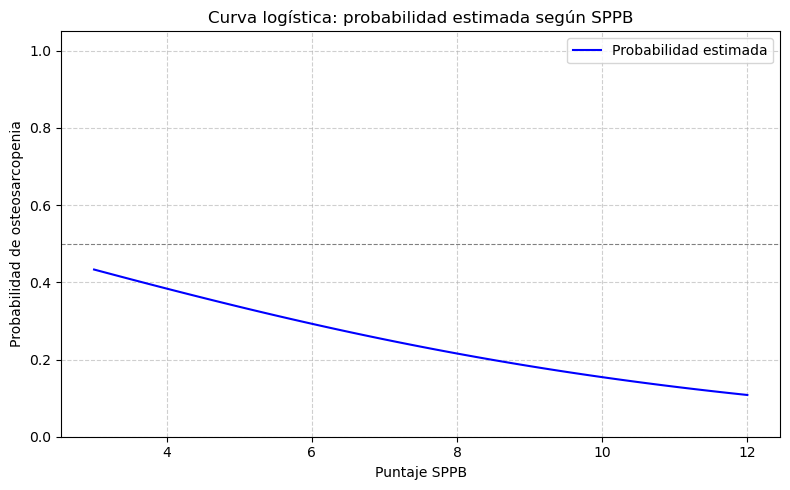

In [58]:
# Crear rango de valores posibles para SPPB
sppb_range = np.linspace(df['puntaje_sppb'].min(), df['puntaje_sppb'].max(), 100)

# Crear dataframe con valores constantes para las otras variables
estado_intermedio = 0
estado_bajo = 0
lawton_fijo = df['resultado_de_lawton'].median()

# DataFrame hipotético para predicción
df_pred = pd.DataFrame({
    'Intercept': 1,
    'C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.intermedio]': estado_intermedio,
    'C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.bajo]': estado_bajo,
    'puntaje_sppb': sppb_range,
    'resultado_de_lawton': lawton_fijo
})

# Calcular la probabilidad estimada de osteosarcopenia
prob = modelo.predict(df_pred)

# Graficar la curva logística
plt.figure(figsize=(8, 5))
plt.plot(sppb_range, prob, label='Probabilidad estimada', color='blue')
plt.xlabel('Puntaje SPPB')
plt.ylabel('Probabilidad de osteosarcopenia')
plt.title('Curva logística: probabilidad estimada según SPPB')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/rl_sppb.png", dpi=300, bbox_inches='tight')
plt.show()

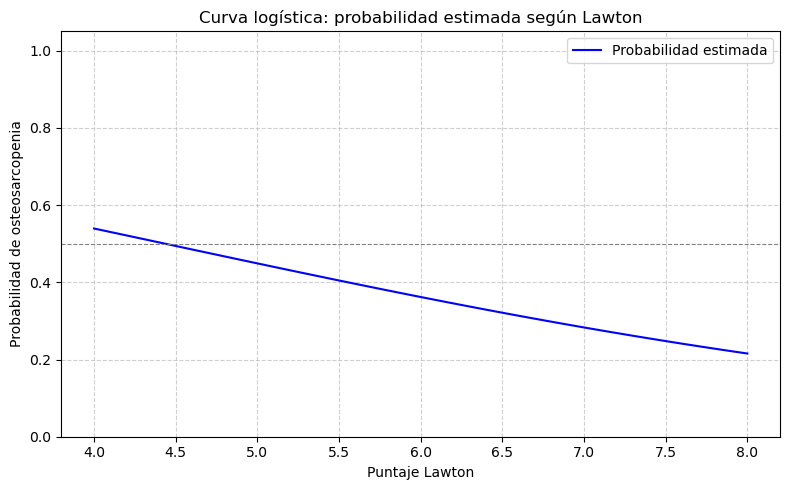

In [57]:
# Crear rango de valores posibles para Lawton
lawton_range = np.linspace(df['resultado_de_lawton'].min(), df['resultado_de_lawton'].max(), 100)

# Valores constantes
estado_intermedio = 0  # dummy variable
estado_bajo = 0        # dummy variable
sppb_fijo = df['puntaje_sppb'].median()

# DataFrame hipotético para predicción
df_pred_lawton = pd.DataFrame({
    'Intercept': 1,
    'C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.intermedio]': estado_intermedio,
    'C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.bajo]': estado_bajo,
    'puntaje_sppb': sppb_fijo,
    'resultado_de_lawton': lawton_range
})

# Calcular la probabilidad estimada
prob_lawton = modelo.predict(df_pred_lawton)

# Graficar la curva logística para Lawton
plt.figure(figsize=(8, 5))
plt.plot(lawton_range, prob_lawton, label='Probabilidad estimada', color='blue')
plt.xlabel('Puntaje Lawton')
plt.ylabel('Probabilidad de osteosarcopenia')
plt.title('Curva logística: probabilidad estimada según Lawton')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/rl_lawton.png", dpi=300, bbox_inches='tight')
plt.show()

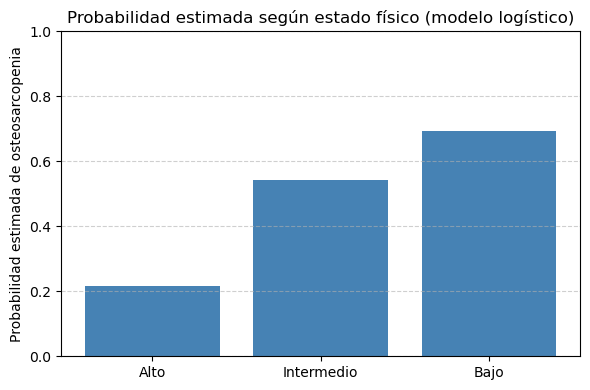

In [60]:
# Medianas fijas
sppb_fijo = df['puntaje_sppb'].median()
lawton_fijo = df['resultado_de_lawton'].median()

# DataFrame para cada estado físico
pred_alto = pd.DataFrame({
    'Intercept': [1],
    'C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.intermedio]': [0],
    'C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.bajo]': [0],
    'puntaje_sppb': [sppb_fijo],
    'resultado_de_lawton': [lawton_fijo]
})
pred_intermedio = pred_alto.copy()
pred_intermedio['C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.intermedio]'] = 1

pred_bajo = pred_alto.copy()
pred_bajo['C(clasificacion_de_estado_fisico, Treatment(reference=\'alto\'))[T.bajo]'] = 1

# Predecir probabilidades
probs = [
    modelo.predict(pred_alto).iloc[0],
    modelo.predict(pred_intermedio).iloc[0],
    modelo.predict(pred_bajo).iloc[0]
]

# Graficar
plt.figure(figsize=(6, 4))
plt.bar(['Alto', 'Intermedio', 'Bajo'], probs, color='steelblue')
plt.ylim(0, 1)
plt.ylabel('Probabilidad estimada de osteosarcopenia')
plt.title('Probabilidad estimada según estado físico (modelo logístico)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("../outputs/rl_estado_fis.png", dpi=300, bbox_inches='tight')
plt.show()